<!-- # Computational Photonics

1. <a id='toc1_'></a>[Homework 1: Implementation of a Finite-Difference Mode Solver](#toc0_)

Author:
*Group 3*
| Name             | Email       |
| -----------      | ----------- |
| *Pooja Asok Kumar*|  *pooja.asok.kumar@uni-jena.de*   |
| *Udit Banerjee*   |             |
| *John Fearnhead*  |             |
| *Yucheng Sun*     |  *yucheng.sun@uni-jena.de*        |
Supervisor:
>Prof. Thomas Pertsch 
Tutor:
>
>
>-->




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import FormatStrFormatter
import scipy as sp
import scipy.sparse as sps
from scipy.sparse.linalg import eigs
import time
%config InlineBackend.figure_format = 'svg'
%matplotlib inline


**Table of contents**<a id='toc0_'></a>    
- 1. [Introduction](#toc1_)    
- 2. [Finite Difference Methods](#toc2_)    
  - 2.1. [Finite difference approximation and errors](#toc2_1_)    
  - 2.2. [Application of finite difference method for the wave equation](#toc2_2_)    
    - 2.2.1. [Simplification of the wave equation](#toc2_2_1_)    
    - 2.2.2. [Discretization of the wave equation](#toc2_2_2_)    
- 3. [Analysis and Simulation of the Problems](#toc3_)    
  - 3.1. [Guided modes in 1+1=2D systems (TE modes)](#toc3_1_)    
    - 3.1.1. [Discussion of physical properties of numerical solutions](#toc3_1_1_)    
    - 3.1.2. [Discussion of numerical properties of numerical solutions](#toc3_1_2_)    
  - 3.2. [Guided modes in 2+1=3D systems (strip waveguide) in scalar approximation](#toc3_2_)    
    - 3.2.1. [Discussion of physical properties of numerical solutions](#toc3_2_1_)    
    - 3.2.2. [Discussion of numerical properties of numerical solutions](#toc3_2_2_)    
- 4. [Conclusions](#toc4_)    
- 5. [References](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>[Introduction](#toc0_)

In this project, we use the finite difference method to find the available eigenmodes and corresponding field distributions of a slab waveguide in 1D case and a strip waveguide in 2D case. And we use *Python* to achieve this method. In addition, both the physical properties and the numerical properties (i.e. the convergence of one specific eigenvalue and operation time of the program with increasing grid size) of the simulation will be discussed.

## 2. <a id='toc2_'></a>[Finite Difference Methods](#toc0_)

The point of the finite difference method to solve the differential equations is to approximate the derivatives by the differential quotients (i.e. finite difference). By doing this, we can change the differential equation into a system of algebraic equations to solve, which can in turn transformed into a matrix representation. By using the matrix representation, the problem can be easily solved using *Python* with library like *numpy* and *scipy*. [1],[2]

### 2.1. <a id='toc2_1_'></a>[Finite difference approximation and errors](#toc0_)

Here, we only consider the one-dimensional case and the derivative of a smooth function $u(x)$, which is given by

   
   \begin{align}
   \tag{1}
      u^{'}(x) = \lim_{h\to 0}\frac{u(x+h)-u(x)}{h},
   \end{align}

   or

   \begin{align}
   \tag{2}
      u^{'}(x) = \lim_{h\to 0}\frac{u(x)-u(x-h)}{h}.
   \end{align}

   These formulas mean that the quotient on the right-hand side provides a very good approximation of the derivative when $h$ tends to $0$. It is claimed that the approximation is good since the the error committed in this approximation (i.e. when replacing the derivative by the forward or backward differential quotient) tends towards zero when $h$ tends to zero. All of these including the error of the approximation is described by the Taylor series,

   \begin{align}
      u(x+h)&=u(x)+hu^{'}(x)+O^{+}(h^2)\tag{3}\\
      &=u(x)+hu^{'}(x)+\frac{h^2}{2}u^{''}(x)+O^{+}(h^3)\tag{4}
   \end{align}

   or

   \begin{align}
      u(x-h)&=u(x)-hu^{'}(x)+O^{-}(h^2)\tag{5}\\
      &=u(x)-hu^{'}(x)+\frac{h^2}{2}u^{''}(x)-O^{-}(h^3)\tag{6}
   \end{align}

   where $O(h^2)$ and $O(h^3)$, representing the errors of the approximation, is given by 
   
   \begin{align}
      O^{\pm}(h^2)&=\frac{h^2}{2}u^{''}(x\pm h_1),\ (x+h_1)\in [x, x+h],\ (x-h_1)\in [x-h, x]\tag{7}\\
      O^{\pm}(h^3)&=\frac{h^3}{6}u^{(3)}(\xi^{\pm}),\ \xi^{+}\in [x, x+h],\ \xi^{-}\in [x-h, x]\tag{8}
   \end{align}

   So the approximation of the derivative can be one of the following three forms with different errors for each one,

   - forward difference
   \begin{align}
      u^{'}(x) \approx \frac{u(x+h)-u(x)}{h}\tag{9},
   \end{align}
   - backward difference
   \begin{align}
      u^{'}(x) \approx \frac{u(x)-u(x-h)}{h}\tag{10},
   \end{align}
   - central difference
   \begin{align}
      u^{'}(x) \approx \frac{u(x+h)-u(x-h)}{2h}\tag{11}.
   \end{align}

   The differences between these equations and the equations $(3)$ and $(5)$ are just the error of these approximation.

   And the approximation of the second derivative can be obtained by adding the equations $(4)$ and $(6)$, which is given by

   \begin{align}
      u^{''}(x) \approx \frac{u(x+h)+u(x-h)-2u(x)}{h^2}\tag{12}
   \end{align}

   and the sum of the rest terms after the addition is just the errors of the approximation.

### 2.2. <a id='toc2_2_'></a>[Application of finite difference method for the wave equation](#toc0_)

#### 2.2.1. <a id='toc2_2_1_'></a>[Simplification of the wave equation](#toc0_)

   In this project, we only focus on the TE-field or quasi TE-field, i.e. linearly polarized field and the discussed structures are weakly guiding structures which means that

   \begin{align}
      \nabla &\cdot \textbf{D}=0,\tag{13}\\
      &\downarrow weakly\ guiding\ structures\ \nabla \epsilon \approx 0\notag\\
      \nabla &\cdot \textbf{E}=0,\tag{14}
   \end{align}

   Thus, in this project, the wave equation is given by
   
   \begin{align}
      \Delta\textbf{E}(\textbf{r}, \omega) &+ \frac{\omega^2}{c^2}\epsilon(\textbf{r}, \omega)\textbf{E}(\textbf{r}, \omega) = 0,\tag{15}\\
      &\downarrow linear\ polarization\notag\\
      &\downarrow scalar\ approximation\notag\\
      \Delta v(\textbf{r}, \omega) &+ \frac{\omega^2}{c^2}\epsilon(\textbf{r}, \omega)v(\textbf{r}, \omega) = 0,\tag{16}
   \end{align}

   Furthermore, we focus on the stationary modes with $\epsilon(\textbf{r},\omega)=\epsilon((x,y),\omega)$ for a single wavelength. That means that what we want here are those certain amplitude profiles (i.e distributions of electric field amplitude) where the intensity profile remains unchanged during propagation (assuming a lossless waveguide). So it is reasonable to assume that

   \begin{align}
      v(\textbf{r})=u(x,y)\exp{(i\beta z)}.\tag{17}
   \end{align}

   Finally, the wave equation is changed into
   
   \begin{align}
      \Delta^{(2)} u(x,y) &+ \frac{\omega^2}{c^2}\epsilon((x,y), \omega)u(x,y) = \beta^2 u(x,y),\tag{18}\\
      &\downarrow\notag\\
      [\Delta^{(2)}+&\frac{\omega^2}{c^2}\epsilon((x,y), \omega)]u(x,y) = \beta^2 u(x,y),\tag{19}
   \end{align}

   which is a eigenvalue problem. $\beta$ is the eigenvalue that we want to find and $u(x,y)$ is the eigenvector which represents the transverse profile of the electric field distribution.

   In conclusion, the final goal of the project can be obtain by solving the eigenvalue problem and its eigenvalues and eigenvectors are what we want.  

#### 2.2.2. <a id='toc2_2_2_'></a>[Discretization of the wave equation](#toc0_)

   To solve the problem, we need to discretize the equation using finite difference method.
  - 1D case
    
    In this case, the equation $(19)$ is given by

    \begin{align}
      [\frac{\partial^2}{\partial^2_{x}}+k^2_0\epsilon(x, \omega)&]u(x)=\beta^2u(x)\tag{20}\\
      &\downarrow\notag\\
      [\frac{1}{k^2_0}\frac{\partial^2}{\partial^2_{x}}+\epsilon(x, \omega)&]u(x)=\frac{\beta^2}{k^2_0}u(x)=\epsilon_{eff}u(x)\tag{21}
    \end{align}

    To use the finite difference method to replace the differential operator with finite difference as shown in equation $(12)$, we need to discretize the structure geometry as shown in the following figure. And the discretized position is represented as $x_i=x_{min}+i\cdot h$.

    <center>
    
    <img src="1d_case_discretization.jpg" alt="1d_case_discretization" width="400" height="400"/>

    Figure 1: Discretization of the 1D case
    
    </center>

    Then we will get a series of algebraic coupled equations,

    \begin{align}
      [\frac{1}{k^2_0}\frac{u(x_i+h)+u(x_i-h)-2u(x_i)}{h^2}&+\epsilon((x_i,y_j),w)]u(x_i,y_j)=\epsilon_{eff}u(x_i,y_j)\tag{22}\\
      &\downarrow x_i+h=x_{i+1},\ x_i-h=x_{i-1} \notag\\
      [\frac{1}{k^2_0}\frac{u(x_{i+1})+u(x_{i-1})-2u(x_i)}{h^2}&+\epsilon((x_i,y_j),w)]u(x_i,y_j)=\epsilon_{eff}u(x_i,y_j)\tag{23}
    \end{align}

    Based on these discretization, we can represent the algebraic function $u(x)$ as a vector,

    \begin{align}
      \textbf{u}^T=[u(x_0), u(x_1), u(x_2), \cdots, u(x_{max})].\tag{24}
    \end{align}

    and the influence of the system (i.e. the differential operators) as a matrix,

    \begin{align}
      M_{1D}=\frac{1}{k^2_0}\left[ \begin{array}{ccccccccccccc}
      -\frac{2}{h^2}+k^2_0\epsilon(x_0, \omega) & \frac{1}{h^2} & 0 & 0 & 0 & 0 & \cdots\\
      \\
      \frac{1}{h^2} & -\frac{2}{h^2}+k^2_0\epsilon(x_1, \omega) & \frac{1}{h^2} & 0 & 0 & 0 & \cdots\\
      \\
      0&\frac{1}{h^2} & -\frac{2}{h^2}+k^2_0\epsilon(x_2, \omega) & \frac{1}{h^2}& 0 & 0 & \cdots\\
      \\
      \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots \\
      \\
      \vdots & \vdots & 0 & \ddots & \ddots & \ddots & \cdots\\
      \\
      \vdots & \vdots & \vdots & 0 & \ddots & \ddots & \ddots\\
      \\
      0 & 0 & 0 & \cdots & \cdots & \cdots & \cdots \end{array} \right]\tag{25}
    \end{align}

    Then the final problem we need to solve is just the eigenvalue problem, 

    \begin{align}
      M_{1D}\textbf{u}=\beta_{eff}\textbf{u}.\tag{26}
    \end{align}

  - 2D case
   
    In this case, the equation $(19)$ is given by

    \begin{align}
      [\frac{\partial^2}{\partial^2_{x}}+\frac{\partial^2}{\partial^2_{y}}+k^2_0\epsilon((x,y), \omega)&]u(x,y)=\beta^2u(x,y)\tag{27}\\
      &\downarrow\notag\\
      [\frac{\partial^2}{\partial^2_{x}}+\frac{\partial^2}{\partial^2_{y}}+\epsilon((x,y), \omega)&]u(x,y)=\frac{\beta^2}{k^2_0}u(x,y)=\epsilon_{eff}u(x,y)\tag{28}
    \end{align}

    <center>

    <img src="2d_case_discretization.jpg" alt="2d_case_discretization" width="400" height="400"/>

    Figure 2: Discretization of the 2D case

    </center>

    Then we will get a series of algebraic coupled equations,

    \begin{align}
      [\frac{1}{k^2_0}\frac{u(x_i+h, y_j)+u(x_i-h, y_j)+u(x_i, y_j+h)+u(x_i, y_j-h)-4u(x_i, y_j)}{h^2}&+\epsilon((x_i,y_j),w)]u(x_i,y_j)=\epsilon_{eff}u(x_i,y_j)\tag{29}\\
      &\downarrow \notag\\
      [\frac{1}{k^2_0}\frac{u(x_{i+1}, y_j)+u(x_{i-1}, y_j)+u(x_i, y_{j+1})+u(x_i, y_{j-1})-4u(x_i, y_j)}{h^2}&+\epsilon((x_i,y_j),w)]u(x_i,y_j)=\epsilon_{eff}u(x_i,y_j)\tag{30}
    \end{align}

    Based on these discretization, we can represent the algebraic function $u(x,y)$ as a matrix,

    \begin{align}
      \textbf{u}=\left[\begin{array}{cccc}
        u(x_0, y_0) & u(x_0, y_1) & \cdots & u(x_0, y_{max}) \\
        u(x_1, y_0) & u(x_1, y_1) & \cdots & u(x_1, y_{max}) \\
        \vdots & \vdots & \vdots & \vdots \\
        u(x_{max}, y_0) & u(x_{max}, y_1) & \cdots & u(x_{max}, y_{max}) 
      \end{array}\right].\tag{31}
    \end{align}

    However, to solve the problem more efficiently, i.e. transform the problem into a more familiar eigenvalue problem, we need to flatten the matrix into a vector,

    \begin{align}
      \textbf(u)^T=[u(x_0, y_0), \cdots, u(x_0, y_{max}), \cdots, u(x_{max}, y_0), \cdots, u(x_{max}, y_{max})].\tag{32}
    \end{align}

    Then the influence of the system (i.e. the differential operators) as a matrix,

    \begin{align}
      M_{2D}=\frac{1}{k^2_0}\left[ \begin{array}{ccccccccccccc}
      -\frac{4}{h^2}+k^2_0\epsilon((x_0,y_0), \omega) & \frac{1}{h^2} & 0 & 0 & \frac{1}{h^2} & 0 & \cdots\\
      \\
      \frac{1}{h^2} & -\frac{4}{h^2}+k^2_0\epsilon((x_1,y_1), \omega) & \frac{1}{h^2} & 0 & 0 & \ddots & \cdots\\
      \\
      0&\frac{1}{h^2} & -\frac{4}{h^2}+k^2_0\epsilon((x_2,y_2), \omega) & \frac{1}{h^2}& 0 & 0 & \cdots\\
      \\
      \vdots & 0 & \ddots & \ddots & \ddots & 0 & \cdots \\
      \\
      \frac{1}{h^2}& \vdots & 0 & \ddots & \ddots & \ddots & \cdots\\
      \\
      \vdots & \ddots & \vdots & 0 & \ddots & \ddots & \ddots\\
      \\
      0 & 0 & \cdots & \cdots & \cdots & \cdots & \cdots \end{array} \right]\tag{33}
    \end{align}

    Then the final problem we need to solve is also the eigenvalue problem, 

    \begin{align}
      M_{2D}\textbf{u}=\beta_{eff}\textbf{u}.\tag{34}
    \end{align}

## 3. <a id='toc3_'></a>[Analysis and Simulation of the Problems](#toc0_)


To use the finite difference method to simulate the problem, the general procedures needed to be achieved in the simulation is given as following, 
1. to obtain the material model (i.e. the profile of permittivity) and other basic parameters, such as the wavelength and geometry of the simulated material,
   
2. to discretize the geometry of the material,
   
3. to create the corresponding matrix that can represent the influence of the material system, which is actually one of the two core parts of the simulation,
   
4. to calculate the eigenmodes of the matrix,
   
5. to select the appropriate eigenmodes which is physically meaningful, which is the other core part of the simulation.

### 3.1. <a id='toc3_1_'></a>[Guided modes in 1+1=2D systems (TE modes)](#toc0_)

- Creation of the matrix and calculation of the eigenmodes and field distribution
  
  This part defines a function which functions to create the corresponding matrix representing the influence of the material system and calculate the eigenmodes  and corresponding field distributions. Here we create the matrix using the for loop.

In [15]:
def guided_modes_1DTE(prm, k0, h):
    """Computes the effective permittivity of a TE polarized guided eigenmode.
    All dimensions are in µm.
    Note that modes are filtered to match the requirement that
    their effective permittivity is larger than the substrate (cladding).
    
    Parameters
    ----------
    prm : 1d-array
        Dielectric permittivity in the x-direction
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated modes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    dt = np.common_type(np.array([prm]))
    # Construct the matrix M for the eigenvalue problem
    M  = np.zeros((len(prm),len(prm)), dtype = dt)
    for i in range(len(prm)):
        M[i][i] =  -2/(h**2) + (k0**2) * prm[i]
        if i > 0:
            M[i][i-1] = 1/(h**2) 
        if i < len(prm) - 1:
            M[i][i+1] = 1/(h**2)
    M  = (1/(k0**2)) * M
    # Solve the eigenvalue problem
    eff_eps, guided = np.linalg.eig(M)
    return eff_eps, guided


- Definition and generation of the parameters and grids

  This part defines the basic parameters and material model of the simulated system and the way to discretize the structure geometry.

In [31]:
# Define the basic parameters and the grids
grid_size     = 120
number_points = 601
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace( -grid_size/2, grid_size/2, number_points )
prm           = e_substrate + delta_e * np.exp(-(xx/w)**2)

# Compute the eigenvalues and eigenvectors
eff_eps, guided = guided_modes_1DTE(prm, k0, h)

#### 3.1.1. <a id='toc3_1_1_'></a>[Discussion of physical properties of numerical solutions](#toc0_)

- Selection of modes (effective permittivity and field distribution)
  
  This part filters the eigenmodes that have physical meaning from all the eigenmodes and plots the transverse mode profile (i.e. transverse electric field distribution) of one certain mode. By changing the parameter *mode_ind*, we can get different mode profile. 
  
  The filter condition is given by

  \begin{align} 
    \epsilon_{cladding} < \epsilon_{eff} < max(\epsilon(x, y)) = \epsilon_{cladding} + \Delta \epsilon.\tag{26}
  \end{align}

  The condition is set as a result of the total internal reflection since we want to confine the light in the structure. Thus the wave should decay in the cladding part, i.e. outside part of central part of the material profile in this project, and oscillate in the core part. To ensure this, equation $(26)$ should be satisfied.

There are  12  modes within the given range.
selected_eff_eps:  2.2500454385848343
selected_guided: 
 [-3.85402401e-04 -7.70850254e-04 -1.15638902e-03 -1.54206415e-03
 -1.92792115e-03 -2.31400551e-03 -2.70036277e-03 -3.08703848e-03
 -3.47407824e-03 -3.86152769e-03 -4.24943252e-03 -4.63783847e-03
 -5.02679133e-03 -5.41633697e-03 -5.80652131e-03 -6.19739036e-03
 -6.58899018e-03 -6.98136695e-03 -7.37456691e-03 -7.76863641e-03
 -8.16362189e-03 -8.55956989e-03 -8.95652707e-03 -9.35454018e-03
 -9.75365613e-03 -1.01539219e-02 -1.05553846e-02 -1.09580916e-02
 -1.13620902e-02 -1.17674280e-02 -1.21741526e-02 -1.25823119e-02
 -1.29919539e-02 -1.34031267e-02 -1.38158786e-02 -1.42302580e-02
 -1.46463137e-02 -1.50640943e-02 -1.54836490e-02 -1.59050267e-02
 -1.63282768e-02 -1.67534488e-02 -1.71805923e-02 -1.76097573e-02
 -1.80409937e-02 -1.84743517e-02 -1.89098816e-02 -1.93476341e-02
 -1.97876598e-02 -2.02300096e-02 -2.06747345e-02 -2.11218857e-02
 -2.15715146e-02 -2.20236726e-02 -2.24784113e-02 -2.2

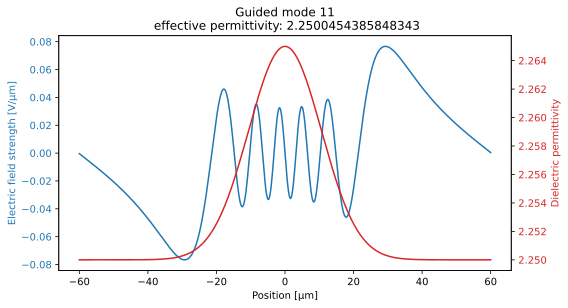

In [52]:
# Filter the eigenvalues and eigenvectors
## Find the indices of the eigenvalues within the given range
indices = np.where((eff_eps >= e_substrate) & (eff_eps <= e_substrate + delta_e))[0]

## Extract the eigenvalues and eigenvectors within the range
selected_eff_eps = eff_eps[indices]
selected_guided = (np.transpose(guided))[indices]
print('There are ', len(selected_eff_eps), ' modes within the given range.')
mode_ind = int(input('Please input an integer:'))
if mode_ind >= 0 & mode_ind < len(selected_eff_eps):
    print('selected_eff_eps: ', selected_eff_eps[mode_ind])
    print('selected_guided: \n', selected_guided[mode_ind])
if mode_ind >= len(selected_eff_eps) | mode_ind < 0:
    print('The input number is out of range. Please input a positive number less than ', len(selected_eff_eps))

# Plot the field distribution of the selected mode and the permittivity
x = xx
y1 = selected_guided[mode_ind]
y2 = prm

fig, ax1 = plt.subplots(figsize=(8, 4))

color = 'tab:blue'
ax1.set_xlabel('Position [µm]')
ax1.set_ylabel('Electric field strength [V/µm]', color=color)
ax1.plot(x, y1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Dielectric permittivity', color=color)
ax2.plot(x, y2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Guided mode ' + str(mode_ind) + '\n effective permittivity: ' + str(selected_eff_eps[mode_ind]))
plt.show()

There are 12 available modes in the case, as shown in Figure 3. After plotting the field distributions of the eigenmodes by changing the *mode_ind*, it is found that the field amplitudes decay to zero out of the central area of the material profile in all cases, which is very reasonable considering the physical meaning of the mode as stated in section 2.2.1. 

>A remark about the numbering of the modes, we use the same numbering as *Python*, which means that the beginning number is $0$ not $1$.

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="2d_mode_0.svg" alt="2d_mode_0" style="width: 30%;">
    <img src="2d_mode_1.svg" alt="2d_mode_1" style="width: 30%;">
    <img src="2d_mode_2.svg" alt="2d_mode_2" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="2d_mode_3.svg" alt="2d_mode_3" style="width: 30%;">
    <img src="2d_mode_4.svg" alt="2d_mode_4" style="width: 30%;">
    <img src="2d_mode_5.svg" alt="2d_mode_5" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="2d_mode_6.svg" alt="2d_mode_6" style="width: 30%;">
    <img src="2d_mode_7.svg" alt="2d_mode_7" style="width: 30%;">
    <img src="2d_mode_8.svg" alt="2d_mode_8" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="2d_mode_9.svg" alt="2d_mode_9" style="width: 30%;">
    <img src="2d_mode_10.svg" alt="2d_mode_10" style="width: 30%;">
    <img src="2d_mode_11.svg" alt="2d_mode_11" style="width: 30%;">
</div>

Figure 3: The field distributions of 12 modes in 1D case

</center>

 For those even modes, their field distributions are even. For those odd modes, their field distributions are odd. And the field amplitude peaks in those modes are the numbering of the mode plus $1$. Also as seen in the above figures, the confinement of the field distributions of the modes, which is the most important part of our consideration about the waveguide modes, become worse for those higher-order modes. We can see this in two ways in the figure above, one is how far the field strength distribution extends in space, and the other is the peak of the field strength distribution. Specifically, as the mode order increases, the extent of the spatial distribution of the corresponding field amplitude increases and the peak of the field amplitude distribution decreases. These modes form a basis (in the mathematical sense), i.e. a complete orthogonal system, for any guided light. In other words, any complex amplitude distribution which is guided by the fiber can be expressed as a linear superposition of the modes. If we want to confine the field better, we need to couple more amplitude to the fundamental mode, i.e. mode $0$, which can help to achieve a smaller spatial extent and also a higher peak field amplitude.

#### 3.1.2. <a id='toc3_1_2_'></a>[Discussion of numerical properties of numerical solutions](#toc0_)

- Analysis of convergence and operational time

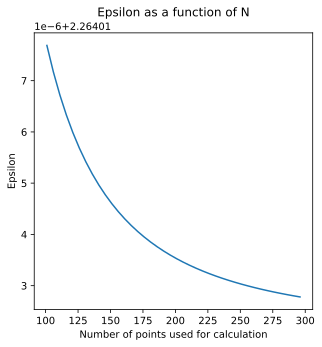

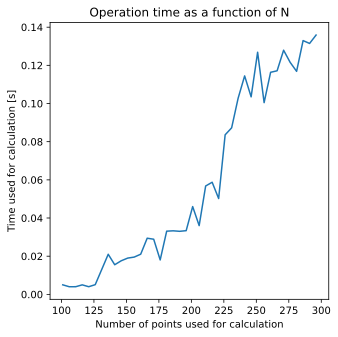

In [23]:
n_count = []
time_operation = []
eff_eps_calculated = []

#define params variable
for i in range(40):
    start_time = time.time()
    number_points = 101 + 5*i
    h             = grid_size/(number_points - 1)
    xx            = np.linspace(-grid_size/2, grid_size/2 ,number_points)
    prm           = e_substrate + delta_e * np.exp(-(xx/w)**2)
    # Compute the eigenvalues and eigenvectors
    eff_eps = guided_modes_1DTE(prm, k0, h)[0]
    max_eff_eps = np.max(eff_eps)
    eff_eps_calculated.append(max_eff_eps)
    n_count.append(number_points)
    time_operation.append(time.time() - start_time)


plt.figure(figsize=(5,5)) #plot
plt.plot(n_count, eff_eps_calculated)
plt.xlabel("Number of points used for calculation")
plt.ylabel("Epsilon")
plt.title("Epsilon as a function of N")
plt.show()

plt.figure(figsize=(5,5)) #plot
plt.plot(n_count, time_operation)
plt.xlabel("Number of points used for calculation")
plt.ylabel("Time used for calculation [s]")
plt.title("Operation time as a function of N")
plt.show()

Numerical analysis relies on the balance between sufficient sampling points and avoiding rounding errors encountered when using extremely large or small numbers (here $\approx 10^{\pm15}$). The number of sampling points in a linearly spaced grid defines the distance between sampling points commonly denoted $h$. As $h$ decreases the number of sampling points increase and the computation time for the program increases. Under sampling results in a solution which does not accurately represent the described system, while oversampling results in long computation times and rounding errors resulting from a limited memory allocation to objects. 

To determine the optimum number of discretization points:
* The expected runtime which directly corresponds to a number of points in the time-number of points graphs. <Use name of graph or reference image>
* An acceptable error margin must be defined which relates to the number of points as seen in the relationship between epsilon and the number of points.<Use name of graph or reference image>

Scaling is another important factor to consider, in the 1+1D case the h scales linearly with the number of computed points and thus approximately linearly with time. In the 2+1D case halving the sampling size results in 4 times as many computed points resulting in a quadratic relationship. The quadratic relationship places heavier costs on the smaller $h$ values. Thus higher dimensions pose a more difficult challenge for reaching a high level or accuracy. 

If the required accuracy requires too much time to compute, the only solution is to alter the hardware running the program, to improve the efficiency of the program or to choose a more effective sampling point placement (for example logarithmic or otherwise).


### 3.2. <a id='toc3_2_'></a>[Guided modes in 2+1=3D systems (strip waveguide) in scalar approximation](#toc0_)

- Creation of the matrix and calculation of the eigenmodes and field distribution
  
  This part defines a function which functions to create the corresponding matrix representing the influence of the material system and calculate the eigenmodes and corresponding field distribution. Considering the limited memory of our computer, we cannot using the for loop to create the whole matrix. Instead, we use *scipy.sparse.diags* function to create a sparse matrix which saves a lot of memories. When creating the matrix, the point is to deal with those elements corresponding to the boundaries of the geometry.

In [54]:
def guided_modes_2D(prm, k0, h, numb):
    """Computes the effective permittivity of a quasi-TE polarized guided 
    eigenmode. All dimensions are in µm.
    
    Parameters
    ----------
    prm  : 2d-array
        Dielectric permittivity in the xy-plane
    k0 : float
        Free space wavenumber
    h : float
        Spatial discretization
    numb : int
        Number of eigenmodes to be calculated
    
    Returns
    -------
    eff_eps : 1d-array
        Effective permittivity vector of calculated eigenmodes
    guided : 2d-array
        Field distributions of the guided eigenmodes
    """
    dt = np.common_type(np.array([prm]))
    # Construct the matrix M for the eigenvalue problem
    diagonals = np.zeros((5, np.size(prm)))
    diagonals[0] = -4/(h**2) + (k0**2) * prm.flatten()
    for i in range(np.size(prm) - 1):
        if i % len(prm[0]) != len(prm[0]) - 1:
            diagonals[1][i] = 1/(h**2)
        if i % len(prm[0]) != 0:
            diagonals[2][i] = 1/(h**2)
        if i < np.size(prm) - len(prm[0]):
            diagonals[3][i] = 1/(h**2)
        if i >= len(prm[0]):
            diagonals[4][i] = 1/(h**2)
    diag_position = [0, 1, -1, len(prm[0]), -len(prm[0])]
    # Create a sparse 2D array with the diagonal elements
    M = sps.diags(diagonals, diag_position)
    M = (1/(k0**2)) * M
    # Compute the eigenvalues and eigenvectors
    eff_eps, guided = sps.linalg.eigs(M, k = numb, which = 'LR')
    return eff_eps, guided

- Definition and generation of the parameters and grids

  This part defines the basic parameters and material model of the simulated system and the way to discretize the structure geometry. We use *numb* to control the number of the eigenmodes that we want to obtain.

In [55]:
# Define the basic parameters and grids
grid_size     = 120
number_points = 301
h             = grid_size/(number_points - 1)
lam           = 0.78
k0            = 2*np.pi/lam
e_substrate   = 2.25
delta_e       = 1.5e-2
w             = 15.0
xx            = np.linspace(-grid_size/2 - h, grid_size/2 + h,number_points + 2)
yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
XX,YY         = np.meshgrid(xx,yy)
prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
numb          = int(input('Please input the number of modes to be calculated: '))

# Compute the eigenvalues and eigenvectors
eff_eps, guided = guided_modes_2D(prm, k0, h, numb)
guided = np.transpose(guided)

#### 3.2.1. <a id='toc3_2_1_'></a>[Discussion of physical properties of numerical solutions](#toc0_)

- Selection of modes (effective permittivity and field distribution)
  
  This part filters the eigenmodes that have physical meaning from all the eigenmodes and plots the transverse mode profile (i.e. transverse electric field distribution) of one certain mode. By changing the parameter *mode_ind*, we can get different mode profiles. Although the basic filter condition is still equation $(26)$, it is not possible to filter all the available eigenmodes here using *if* condition as in 1D case since we have defined the number of modes we need to obtain and need to consider the limited memories of our computer and computing time. Our solution here is to use the *'which = LR'* comment in the function *sps.linalg.eigs* to achieve the filtering process, which means that the function will return the eigenvalues with the largest real part. Then we can increase the number of the eigenmodes, i.e. *numb*, to find all the available eigenmodes. By doing this, we increase *numb* continuously for several time and find there are 54 modes in total. Their effective permittivity is shown in the following array.
  \begin{align}
    \left[\begin{array}{cccc}
      2.26304453+0.j & 2.26116279+0.j & 2.26116279+0.j & 2.25942948+0.j\\
      2.25935949+0.j & 2.25935494+0.j & 2.25777615+0.j & 2.25763071+0.j\\
      2.25777615+0.j & 2.25763071+0.j & 2.25627948+0.j & 2.25621198+0.j\\
      2.25620119+0.j & 2.2559873 +0.j & 2.25598717+0.j & 2.25487282+0.j\\
      2.25487282+0.j & 2.254726  +0.j & 2.254726  +0.j & 2.25443155+0.j\\
      2.25443155+0.j & 2.25363597+0.j & 2.25357064+0.j & 2.25355469+0.j\\
      2.25334228+0.j & 2.25334193+0.j & 2.25297023+0.j & 2.25297023+0.j\\
      2.25250659+0.j & 2.25250659+0.j & 2.25235955+0.j & 2.25235955+0.j\\
      2.25206458+0.j & 2.25206458+0.j & 2.25157093+0.j & 2.2515071 +0.j\\
      2.25148995+0.j & 2.25161274+0.j & 2.25127995+0.j & 2.25128036+0.j\\
      2.25161274+0.j & 2.2509097 +0.j & 2.2509097 +0.j & 2.25077942+0.j\\
      2.25077942+0.j & 2.25063801+0.j & 2.25063801+0.j & 2.25024067+0.j\\
      2.25018187+0.j & 2.25017169+0.j & 2.25037431+0.j & 2.25037431+0.j\\
      2.25035238+0.j & 2.25035238+0.j & &
    \end{array}\right].\notag
  \end{align}

There are  10  modes computed.
The effective permittivity of the modes are: 
 [2.26304305+0.j 2.26115868+0.j 2.26115868+0.j 2.2594208 +0.j
 2.25935066+0.j 2.25934865+0.j 2.25776268+0.j 2.25761929+0.j
 2.25761929+0.j 2.25776268+0.j]
selected_eff_eps:  (2.257762683571771+0j)
selected_guided: 
 [ 2.60734949e-16+0.j  3.58432422e-18+0.j  1.38615189e-17+0.j ...
 -1.02335257e-17+0.j -7.96555453e-18+0.j -4.75187906e-18+0.j]


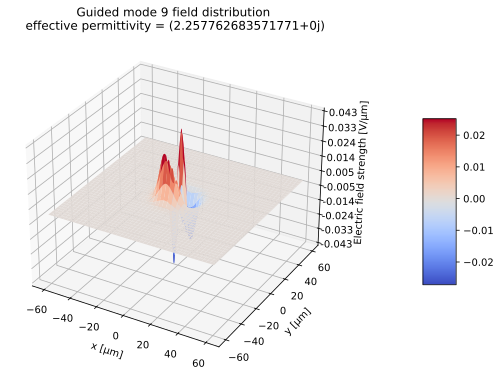

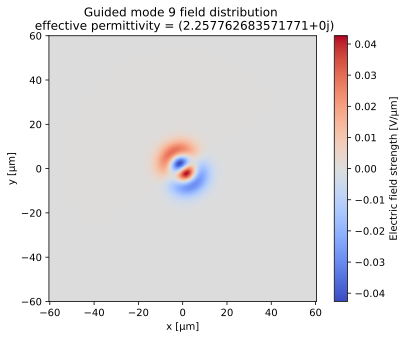

In [69]:
print('There are ', numb, ' modes computed.')
print('The effective permittivity of the modes are: \n', eff_eps)
mode_ind = int(input('Please input an integer:'))
if mode_ind >= 0 & mode_ind < numb:
    print('selected_eff_eps: ', eff_eps[mode_ind])
    print('selected_guided: \n', guided[mode_ind])
if mode_ind >= numb | mode_ind < 0:
    print('The input number is out of range. Please input an integer less than ', numb)


# Plot the eigenmode(3d plot)
X, Y = XX, YY
Z = np.real(guided[mode_ind].reshape((number_points , number_points + 2)))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(30, 6))
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
## Customize the z axis.
ax.set_zlim(np.min(Z), np.max(Z))
ax.zaxis.set_major_locator(LinearLocator(10))
ax.set_title('Guided mode ' + str(mode_ind) + ' field distribution' '\n effective permittivity = ' + str(eff_eps[mode_ind]))
ax.set_xlabel('x [µm]', fontsize=10)
ax.set_ylabel('y [µm]', fontsize=10)
ax.set_zlabel('Electric field strength [V/µm]', fontsize=10)
Z_formatter = FormatStrFormatter('%.3f')
ax.zaxis.set_major_formatter(Z_formatter)
## Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Plot the eigenmode(2d plot)
X, Y = XX, YY
Z = np.real(guided[mode_ind].reshape((number_points , number_points + 2)))
fig, ax = plt.subplots()
im = ax.imshow(Z, cmap='coolwarm', extent=[-grid_size/2 - h , grid_size/2 + h, -grid_size/2, grid_size/2])
fig.colorbar(im, ax=ax, label='Electric field strength [V/µm]')
ax.set_title('Guided mode ' + str(mode_ind) + ' field distribution \n effective permittivity = ' + str(eff_eps[mode_ind]))
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
plt.show()

Since it is a little lengthy to show the field distributions of all the modes here, we only show $10$ of them.
2.26304305+0.j 2.26115868+0.j 2.26115868+0.j 2.2594208 +0.j
 2.25935066+0.j 2.25934865+0.j 2.25776268+0.j 2.25761929+0.j
 2.25761929+0.j 2.25776268+0.j
<center>

<div style="display: flex; justify-content: space-between;">
    <img src="3d_mode_0.svg" alt="3d_mode_0" style="width: 30%;">
    <img src="3d_mode_3.svg" alt="3d_mode_3" style="width: 30%;">
    <img src="3d_mode_2.svg" alt="3d_mode_2" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="3d_mode_3.svg" alt="3d_mode_3" style="width: 30%;">
    <img src="3d_mode_4.svg" alt="3d_mode_4" style="width: 30%;">
    <img src="3d_mode_5.svg" alt="3d_mode_5" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="3d_mode_6.svg" alt="3d_mode_6" style="width: 30%;">
    <img src="3d_mode_7.svg" alt="3d_mode_7" style="width: 30%;">
    <img src="3d_mode_8.svg" alt="3d_mode_8" style="width: 30%;">
</div>

</center>

<center>

<div style="display: flex; justify-content: space-between;">
    <img src="3d_mode_9.svg" alt="3d_mode_9" style="width: 30%;">
</div>

Figure 4: The field distributions of 10 modes in 2D case

</center>

#### 3.2.2. <a id='toc3_2_2_'></a>[Discussion of numerical properties of numerical solutions](#toc0_)

- Analysis of convergence and operational time
  
  To make this part operate quickly and also the plot more clear, we recommend to set the *numb* as $1$.

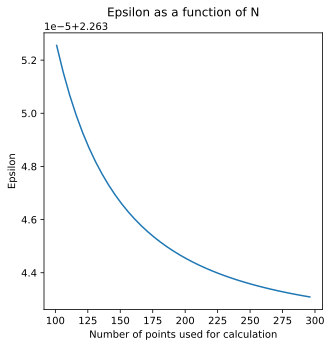

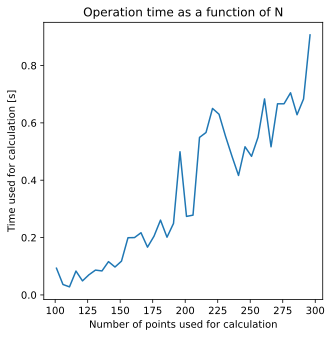

In [13]:
n_count = []
time_operation = []
epsilon_calculated = []
# Define params variable
for i in range(40):
    start_time = time.time()
    number_points = 101 + 5*i
    h             = grid_size/(number_points - 1)
    xx            = np.linspace(-grid_size/2 - h,grid_size/2 + h,number_points + 2)
    yy            = np.linspace(-grid_size/2,grid_size/2,number_points)
    XX,YY         = np.meshgrid(xx,yy)
    prm           = e_substrate + delta_e * np.exp(-(XX**2+YY**2)/w**2)
    # Compute the eigenvalues and eigenvectors
    eff_eps = guided_modes_2D(prm, k0, h, numb)[0]
    epsilon_calculated.append(np.real(eff_eps))
    n_count.append(number_points)
    time_operation.append(time.time() - start_time)

# Plot convergence of the effective permittivity with increasing number of points
plt.figure(figsize=(5,5))
plt.plot(n_count, epsilon_calculated)
plt.xlabel("Number of points used for calculation")
plt.ylabel("Epsilon")
plt.title("Epsilon as a function of N")
plt.show()

# Plot the operational time with increasing number of points
plt.figure(figsize=(5,5)) #plot
plt.plot(n_count, time_operation)
plt.xlabel("Number of points used for calculation")
plt.ylabel("Time used for calculation [s]")
plt.title("Operation time as a function of N")
plt.show()

## 4. <a id='toc4_'></a>[Conclusions](#toc0_)

## 5. <a id='toc5_'></a>[References](#toc0_)

[1]. Qingkai Kong; Timmy Siauw; Alexandre M. Bayen (2021): Chapter 23 - Boundary-Value Problems for Ordinary Differential Equations (ODEs).
   In Qingkai Kong, Timmy Siauw, Alexandre M. Bayen (Eds.): Python Programming and Numerical Methods: Academic Press, pp. 399–414. Available online at https://www.sciencedirect.com/science/article/pii/B9780128195499000336.

[2]. Wikipedia contributors (2024): Finite difference method ‐- Wikipedia, The Free Encyclopedia. Available online at 
   https://en.wikipedia.org/w/index.php?title=Finite_difference_method&oldid=1211001443.
